# Glycosylating a protein

In this Colab Notebook we will explore an example case where we glycosylate a protein. We will use part of the HIV-1 envelope protein 4TVP which is heavily glycosylated. Here we will attach a Mannose 9 glycan to some of it's N-glycosylation sites.

In [1]:
# install glycosylator to Colab
!pip install glycosylator

In [ ]:
import glycosylator as gl
import requests

First we load the protein scaffold and the glycan from a PDB file. We can of course make the glycan live, but we happen to have it as a PDB already.

In [ ]:
%%capture

protein_url = "https://github.com/ibmm-unibe-ch/glycosylator/blob/main/docs/source/examples/files/4tvp.prot.pdb"
response = requests.get(protein_url)
with open("./protein.pdb", "w") as file:
    file.write(response.text)

glycan_url = "https://github.com/ibmm-unibe-ch/glycosylator/blob/main/docs/source/examples/files/man9.pdb"
response = requests.get(glycan_url)
with open("./glycan.pdb", "w") as file:
    file.write(response.text)

<Axes: >

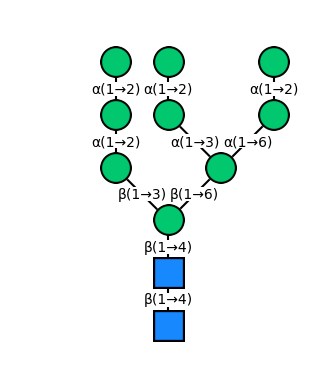

In [2]:
# load the protein
protein = gl.protein("./protein.pdb")
protein.reindex() # reindexing the atoms is usually a good idea to avoid problems

# # and now we get the glycan to attach
glycan = gl.glycan("./glycan.pdb")
glycan.snfg()

Now with that done, we can search for N-glycosylation sites in our protein. To do so we can use the `find_n_linked_sites()` method of the `Protein` class, which will search the protein sequence for the right matches in each protein chain:

In [3]:
# search for glycosylation sites
# (this will return a dictionary with lists of residues in each chain)
sites = protein.find_n_linked_sites()

for chain, residues in sites.items():
    print(chain)
    for r in residues:
        print("  -", r)

{Chain(A): [Residue(ASN, 58), Residue(ASN, 103), Residue(ASN, 107), Residue(ASN, 118), Residue(ASN, 122), Residue(ASN, 158), Residue(ASN, 195), Residue(ASN, 223), Residue(ASN, 237), Residue(ASN, 256), Residue(ASN, 262), Residue(ASN, 291), Residue(ASN, 298), Residue(ASN, 314), Residue(ASN, 322), Residue(ASN, 345), Residue(ASN, 351), Residue(ASN, 358), Residue(ASN, 395), Residue(ASN, 409)], Chain(B): [Residue(ASN, 525), Residue(ASN, 532), Residue(ASN, 539), Residue(ASN, 551)]}


Great! Now we can start glycosylating. Let's say we glycosylate some sites in chain A and some in chain B

In [4]:
# get some sites to glycosylate
sites = sites[protein.get_chain("A")][:2] + sites[protein.get_chain("B")][:2]

# since we need information about the connectivity of the target amino acids we must
# add known reference bonds or infer them (since we are working with a protein we can use the standard amino acid bonds)
protein.apply_standard_bonds_for(*sites)


# now glycosylate the protein
protein.glycosylate(glycan, residues=sites)

Protein(4tvp.prot)

And that's it already! We can now inspect the protein in 2D SNFG schematic:

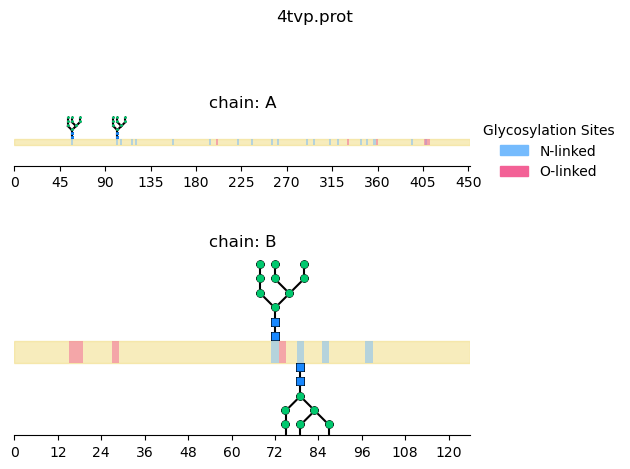

In [ ]:
protein.snfg()

And there are our five glycans attached to chain A! We can also look at the 3D conformation. Let's use `py3dmol` for this one!

In [ ]:
protein.py3dmol().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now that we have a basic glycosylated protein we can save it to a new PDB file

In [10]:
protein.to_pdb("./files/protein_glycosylated.pdb")

# Optimizing a glycosylated protein

If we inspect the 3D structure we may find that some of the glycans look rather sad because they may be clashing with each other or parts of the protein. That is because the geometry of the protein as well as the presence of other glycans is not really considered when attaching glycans. However, we can address these issues by optimizing the structure now. 

Glycosylator can be used seemlessly within BuildAMol's optimization framework to improve the glycan conformations. Be sure to check out the [BuildAMol tutorial on optimization](https://biobuild.readthedocs.io/en/latest/examples/optimization.html) to get more details if you are interested! In short, to optimize structures we need to perform four steps: 

(1) make a graph representation of the molecule to optimize and choose bonds to rotate around in order to optimize the conformation

(2) select an optimization environment to evaluate the quality of new conformations

(3) solve the environment to find a good conformation

Here we will outline how we can do this for our glycosylated protein:

In [11]:
# let's make a copy so we can have a comparison
protein_to_optimize = protein.copy()

### Step 1 - making a graph

The first step is to get a graph for the protein. We can either use `Protein.get_atom_graph()` or `Protein.get_residue_graph()` to do so. If you are working on a not so powerful machine and have a large system with many glycans you should go for the residue graph, however. 

Glycosylator also ships with a dedicated function named `make_scaffold_graph` which creates a residue graph and samples some edges to optimize automatically - so it's a convenience function that handles the preprocessing to get a downsized residue graph which should still yield good results when used for optimization. 

To use it we can do:

In [12]:
# glycosylator comes with a pre-made function to perform steps 1 and 2 automatically. 
# It produces a ResidueGraph for the scaffold and a list of edges that belong to the glycan residues, for optimization.
graph, edges = gl.optimizers.make_scaffold_graph(protein_to_optimize, only_clashing_glycans=True, include_root=True, slice=3)
print(len(graph.nodes), len(edges))

917 15


### Step 2 - making an environment

Now that we have a graph and edges, we need to setup a an environment to evaluate conformations. BuildAMol offers three environments to choose from: the `DistanceRotatron`, the `OverlapRotatron`, and the `ForceFieldRotatron`. The latter is going to require a lot of computation given how large the system is we are trying to optimize so it's best to stay away from that one! For this example we will use the default `DistanceRotatron` which will aim to maximize inter-atomic distances.

In addition to these three basic environments, Glycosylator is equipped with the `ScaffoldRotatron` which adds a little extra on top of either of the three environments mentioned above in order to incentivize conformations that make glycans extend away from the protein surface. We will ultimately use this environment to optimize our protein. Here's how:

In [14]:
# make the basic environment for conformation evaluation
base_env = gl.DistanceRotatron(graph, edges, pushback=2, clash_distance=1.8)

# now make the ScaffoldRotatron to incentivize the glycans to stay away from the protein surface
env = gl.ScaffoldRotatron(base_env)

### Step 3 - optimizing

Now we can use the environment to optimize our glycoprotein. We can use the `optimize` function to solve the environment using an optimization algorithm. We will use a particle-swarm optimization. We could pass more arguments here to further guide the behavior of the swarm optimization...

In [15]:
protein_to_optimize = gl.optimizers.optimize(protein_to_optimize, env, algorithm="swarm")

And now we can compare the before-after:

In [16]:
view = protein.py3dmol(color="gray", glycan_color="red")
for g in protein_to_optimize.glycans:
    view.add(g.py3dmol(color="cyan"))
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

And there we have it! We can now also save our final protein to a PDB file:

In [17]:
protein_to_optimize.to_pdb("./files/protein_optimized.pdb")

That's for this tutorial. You can now glycosylate your own proteins. Of course, the part about optimization is only illustrative and you may need to tinker around to fit it to your system. Thanks for checking out this tutorial and good luck in your project using Glycosylator!